# <h1 style="color:#2E86C1; text-align:center; font-size:2.8em; font-family: 'Segoe UI', Verdana, Geneva, Tahoma, sans-serif; letter-spacing:2px; margin-top:40px;">
#   PRUEBA TÉCNICA PARA CAMBRIAN INTELLIGENCE
# </h1>
# <h3 style="color:#117864; text-align:center; font-size:1.5em; font-family: 'Segoe UI', Verdana, Geneva, Tahoma, sans-serif; margin-bottom:40px;">
#   Autor: Alberto López Casanova
# </h3>

## EDA 



En primer lugar, vamos a realizar un analisis exploratorio de datos para entender el tipo de frases que tenemos y sacar estadisticas que puedan ser de valor

In [61]:
# Importamos las librerías necesarias

import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from difflib import SequenceMatcher
from sklearn.cluster import AgglomerativeClustering
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


---

### 1. CARGA Y VISUALIZACIÓN INICIAL

En primer lugar cargamos el archivo, que está en formato JSON.

In [39]:
with open('sentences.json', 'r') as f:
    sentences = json.load(f)

Hacemos un análisis básico para entender el dataset que tenemos

In [40]:
print(f"Total de frases: {len(sentences)}")

Total de frases: 100


In [41]:
print("Primeras 5 frases:")
for p in sentences[:5]:
    print("-", p)

Primeras 5 frases:
- The dragonfly's wings sparkled like gemstones in the sunlight.
- The bagpipes were adorned with a tartan pattern, honoring Scottish tradition.
- The fur pattern on the tiger was striking and intimidating.
- The triangle was simple but required precise timing.
- The sequoia tree was so tall it seemed to touch the sky.


In [42]:
print("Frases aleatorias del dataset:")
for p in random.sample(sentences, 5):
    print("-", p)

Frases aleatorias del dataset:
- The petals of the rose were arranged in perfect symmetry.
- The theremin was unique in that it required no physical contact to play.
- The painting was done in shades of blue, evoking a sense of calm.
- The pumpkin vine spread out over a vast area, dominating the garden.
- The dandelion seed head formed a delicate sphere, ready to be carried away by the wind.


Antes de realizar un análisis más profundo de las estadísticas y los patrones de lenguaje en las distintas frases, podemos notar a simple vista un patrón recurrente: generalmente comienzan con “The” seguido de un sustantivo, para luego describir alguna característica de este. Además, utilizan estructuras típicas de descripciones, como analogías o comparaciones.

---

### 2. ANÁLISIS BÁSICO

En primer lugar, analizamos métricas básicas, como la longitud de las frases, el número de caracteres y algunas estadísticas descriptivas. Para ello, crearemos un DataFrame que contenga cada frase junto con el número de palabras y número de caracteres correspondientes.

In [43]:
df = pd.DataFrame({
    "phrase": sentences,
    "words": [len(p.split()) for p in sentences],
    "num_chars": [len(p) for p in sentences],
})

df.head()

,phrase,words,num_chars
0,The dragonfly's wings sparkled like gemstones ...,9,62
1,The bagpipes were adorned with a tartan patter...,11,77
2,The fur pattern on the tiger was striking and ...,10,59
3,The triangle was simple but required precise t...,8,52
4,The sequoia tree was so tall it seemed to touc...,12,56


A continuación, obtenemos los estadísticos básicos de las columnas o características “words” (número de palabras) y “num_chars” (número de caracteres).

In [44]:
df.describe()

,words,num_chars
count,100.000000,100.000000
mean,11.490000,68.110000
std,2.012562,8.874996
min,8.000000,52.000000
25%,10.000000,62.000000
50%,11.000000,66.000000
75%,13.000000,74.250000
max,18.000000,90.000000


En general, se observa que, dado que la media de palabras por frase es 11.49 y la desviación estándar es 2.02, se puede afirmar que la longitud de las frases, en términos de palabras, es bastante uniforme.

En cuanto al número de caracteres, la desviación estándar es mayor, lo cual es normal, ya que algunas palabras pueden ser más largas que otras.

A continuación pasamos a graficar la distribución de la longitud de las frases tanto en palabras como en caracteres

In [45]:
# Configuración de estilo para gráficos
sns.set_theme(style="whitegrid")

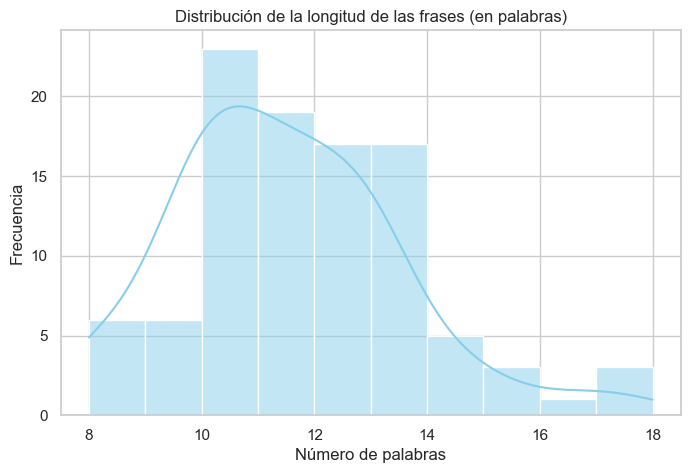

In [46]:
# Histograma de número de palabras por frase
plt.figure(figsize=(8, 5))
sns.histplot(df["words"], bins=10, kde=True, color="skyblue")
plt.title("Distribución de la longitud de las frases (en palabras)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

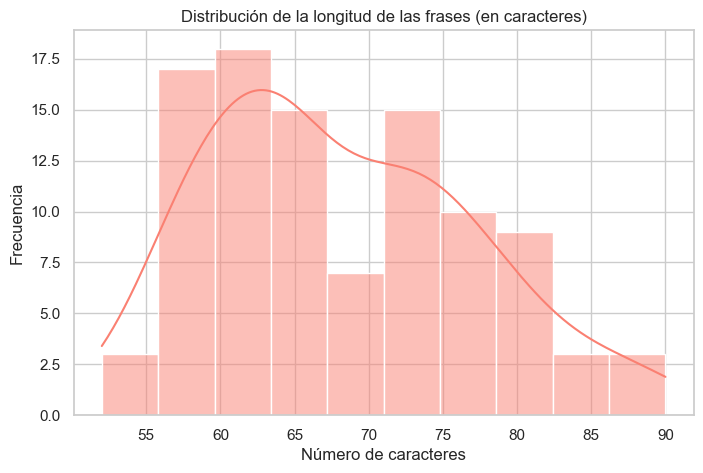

In [47]:
# Histograma de número de caracteres por frase
plt.figure(figsize=(8, 5))
sns.histplot(df["num_chars"], bins=10, kde=True, color="salmon")
plt.title("Distribución de la longitud de las frases (en caracteres)")
plt.xlabel("Número de caracteres")
plt.ylabel("Frecuencia")
plt.show()

 **Análisis gráfico de la longitud de las frases**
 
- **Distribución de palabras:**  
   La mayoría de las frases tienen entre 10 y 13 palabras, lo que indica que son descriptivas, pero no excesivamente cortas ni largas.

- **Forma de la distribución:**  
   Tanto para palabras como para caracteres, la distribución se asemeja a una campana de Gauss (distribución normal). Esto sugiere que las frases han sido escritas o seleccionadas de manera consciente y consistente, con alto contenido semántico.
 
- **Rango y homogeneidad:**  
  El rango de longitudes es estrecho y la forma de la distribución es compacta, lo que confirma que las frases son muy similares en extensión.

- **Comparación con otros textos:**  
   Si la distribución fuera asimétrica o con gran variación, podríamos pensar en textos no depurados (por ejemplo, transcripciones de diálogos). No es el caso aquí.

 
**Conclusiones principales:**
 
- La mayoría de las frases tienen entre 10 y 13 palabras, con una moda cercana a 11.
- El patrón observado sugiere un estilo de escritura controlado y descriptivo.
- Las frases son lo suficientemente largas para expresar ideas completas, pero no tanto como para perder coherencia semántica.
- Esta longitud es ideal para tareas de representación semántica mediante embeddings.

---

### 3. ANALISIS ESTRUCTURAL Y GRAMATICAL CON SPACY

In [48]:
# Carga del modelo de spaCy, basado en arquitectura Transformer para más precisión

nlp = spacy.load("en_core_web_trf")

Primero analizamos la **estructura gramatical** de las frases, **tokenizando** cada una de ellas y extrayendo tanto la **categoría gramatical** de cada token como su **relación de dependencia sintáctica**.

- **POS (Part-of-Speech Tagging):** proceso de **etiquetar la categoría gramatical** de cada palabra (sustantivo, verbo, adjetivo, etc.).  
- **DEP (Dependency Parsing):** indica la **función sintáctica de una palabra dentro de la oración** y su **relación con las demás palabras**.

In [49]:
# Procesarlas en bloque para eficiencia
docs = list(nlp.pipe(sentences))

# Extraer estructura POS+DEP para cada frase
estructuras = []
for doc in docs:
    estructura = [f"{token.pos_}_{token.dep_}" for token in doc]
    estructuras.append(estructura)

Una vez tenemos la estructura gramatical de cada frase con POS y DEP, pasamos a comparar todas ellas con el fin de averiguar si las estructuras utilizadas son parecidas o no a nivel de sintaxis. Para ello usamos SequenceMatcher que básicamente mide la simulitud de las secuencias a comparar. Es importante destacar que no mide la similitud semántica, para ello es mejor usar embeddings como se hace más adelante en este notebook.

In [50]:
def sim_seq(seq1, seq2):
    return SequenceMatcher(None, seq1, seq2).ratio()

n = len(estructuras)
sim_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i, n):
        sim = sim_seq(estructuras[i], estructuras[j])
        sim_matrix[i][j] = sim
        sim_matrix[j][i] = sim

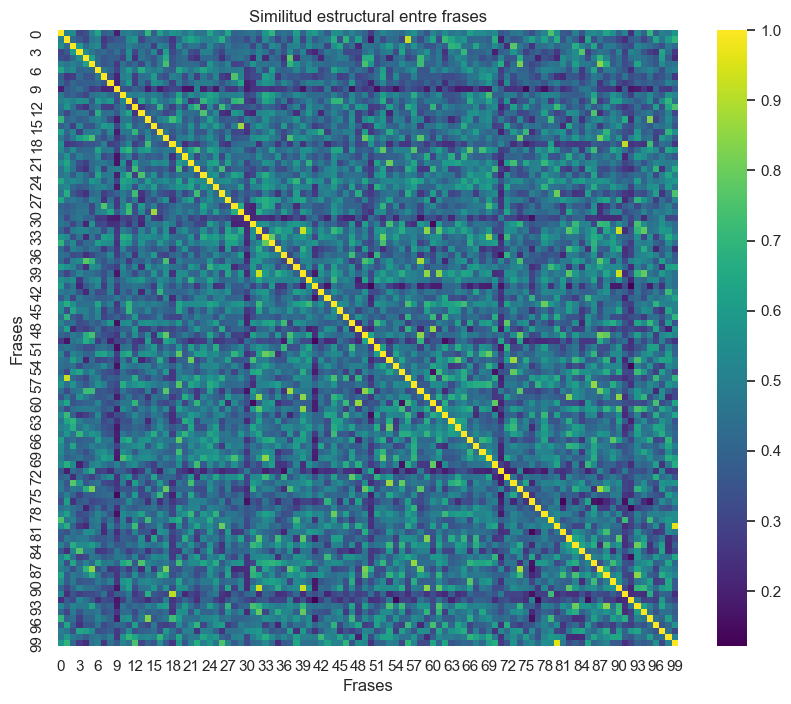

In [51]:
#Graficamos la matriz de similitud estructural

plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix, cmap="viridis")
plt.title("Similitud estructural entre frases")
plt.xlabel("Frases")
plt.ylabel("Frases")
plt.show()

Con el fin de identificar **outliers** en el dataset en cuanto a **estructura gramatical**, podemos enumerar las frases que no cumplen con un umbral de media de similitud léxica con el resto de frases.

In [52]:
# Similitud media por frase

media_similitud = sim_matrix.mean(axis=1) # Importante media de similitud a lo largo de las filas ya que la matriz es simétrica

umbral_unicidad = 0.4 # Este umbral se puede ajustar según el caso
for i, sim in enumerate(media_similitud):
    if sim < umbral_unicidad:
        print(f"Frase única o rara [{i}]: {sentences[i]} (media similitud = {sim:.2f})")


Frase única o rara [7]: The porcupine had quills that could detach when threatened. (media similitud = 0.40)
Frase única o rara [9]: The origami crane was minute but intricately folded. (media similitud = 0.29)
Frase única o rara [18]: The sitar's complex architecture made it visually fascinating. (media similitud = 0.37)
Frase única o rara [30]: Compared to other birds, the condor's wingspan was extraordinary. (media similitud = 0.32)
Frase única o rara [41]: Compared to the cargo ships, the jet ski appeared as tiny as a minnow in a pond. (media similitud = 0.36)
Frase única o rara [48]: The accordion was decorated with ornate patterns that gave it an old-world charm. (media similitud = 0.40)
Frase única o rara [50]: The blue orchids were so vibrant they looked almost unreal. (media similitud = 0.35)
Frase única o rara [71]: The fire truck's red hue was so vivid that it could be spotted miles away. (media similitud = 0.31)
Frase única o rara [76]: The maracas were hand-painted, each t

Es importante recordar que estos son outliers en cuanto a estructura gramatical se refiere, sin embargo, semánticamente no tiene por qué serlo pues pueden estar relacionadas en cuanto a significado con otras de las frases del dataset.

In [ ]:
# ESTE CODIGO HA SIDO CO-GENERADO CON AI

# Convertimos la matriz de similitud a distancia
dist_matrix = 1 - sim_matrix

clustering = AgglomerativeClustering(
    n_clusters=6,
    metric='precomputed', #Para indicar que la entrada es una matriz de distancias y no datos de características, 
    linkage='average'     #linkage recomendado para distancias precomputadas
)
labels = clustering.fit_predict(dist_matrix)


# Mostrar frases por grupo
df = pd.DataFrame({
    "frase": sentences,
    "estructura": [" ".join(e) for e in estructuras],
    "grupo": labels
})

for g in sorted(df["grupo"].unique()):
    print(f"\nGrupo {g}")
    display(df[df["grupo"] == g].head(5))  # Mostramos 5 ejemplos por grupo


Grupo 0


,frase,estructura,grupo
0,The dragonfly's wings sparkled like gemstones ...,DET_det NOUN_poss PART_case NOUN_nsubj VERB_RO...,0
6,The mimosa plant responded to touch by folding...,DET_det NOUN_compound NOUN_nsubj VERB_ROOT ADP...,0
7,The porcupine had quills that could detach whe...,DET_det NOUN_nsubj VERB_ROOT NOUN_dobj PRON_ns...,0
8,The dandelion seed head formed a delicate sphe...,DET_det NOUN_compound NOUN_compound NOUN_nsubj...,0
10,The didgeridoo produced a haunting sound that ...,DET_det NOUN_nsubj VERB_ROOT DET_det VERB_amod...,0



Grupo 1


,frase,estructura,grupo
1,The bagpipes were adorned with a tartan patter...,DET_det NOUN_nsubjpass AUX_auxpass VERB_ROOT A...,1
12,The petals of the rose were arranged in perfec...,DET_det NOUN_nsubjpass ADP_prep DET_det NOUN_p...,1
22,The aloe vera plant was known for its medicina...,DET_det NOUN_compound NOUN_compound NOUN_nsubj...,1
26,The spacecraft was equipped with advanced life...,DET_det NOUN_nsubjpass AUX_auxpass VERB_ROOT A...,1
43,"The kazoo was often underestimated, but it cou...",DET_det NOUN_nsubjpass AUX_auxpass ADV_advmod ...,1



Grupo 2


,frase,estructura,grupo
30,"Compared to other birds, the condor's wingspan...",VERB_prep ADP_prep ADJ_amod NOUN_pobj PUNCT_pu...,2
41,"Compared to the cargo ships, the jet ski appea...",VERB_prep ADP_prep DET_det NOUN_compound NOUN_...,2



Grupo 3


,frase,estructura,grupo
92,The theremin was unique in that it required no...,DET_det X_nsubj AUX_ROOT ADJ_acomp SCONJ_mark ...,3



Grupo 4


,frase,estructura,grupo
9,The origami crane was minute but intricately f...,DET_det NOUN_compound NOUN_nsubjpass AUX_auxpa...,4



Grupo 5


,frase,estructura,grupo
2,The fur pattern on the tiger was striking and ...,DET_det NOUN_compound NOUN_nsubj ADP_prep DET_...,5
3,The triangle was simple but required precise t...,DET_det NOUN_nsubj AUX_ROOT ADJ_acomp CCONJ_cc...,5
4,The sequoia tree was so tall it seemed to touc...,DET_det NOUN_compound NOUN_nsubj AUX_ROOT ADV_...,5
5,The microchip was so small it could be embedde...,DET_det NOUN_nsubj AUX_ROOT ADV_advmod ADJ_aco...,5
16,The length of the train seemed to stretch into...,DET_det NOUN_nsubj ADP_prep DET_det NOUN_pobj ...,5



**Conclusiones principales:**
 
- Las frases tiene una estructura gramatical parecida, incluyendo todas tanto DET como NOUN y ADJ.
- La estructura gramatical de las frases nos indica que como se puede observar a simple vista, se trata de descripciones.
- Las agrupaciones o clusters obtenidos tienen relación en cuanto a estructura gramatical, pero no en cuanto a semántica.

---

### 4. ANALISIS SEMANTICO CON SBERT


En este apartado realizamos el **análisis semántico** de las diferentes frases, es decir, buscamos comprender la relación que existe entre ellas en términos de significado. Para ello, utilizamos **Sentence-BERT (SBERT)**, un modelo derivado de **BERT** que emplea la arquitectura **Transformer** en su componente **encoder** para generar **embeddings contextuales**. Estos embeddings capturan el significado semántico de los textos y permiten representarlos en un espacio vectorial donde frases similares quedan próximas entre sí.  

Gracias a esta representación vectorial, SBERT permite realizar diversas tareas de **procesamiento de lenguaje natural** orientadas a la semántica, tales como:  

- **Clustering de frases o documentos**, agrupando textos por similitud de significado.  
- **Búsqueda semántica (semantic search)**, recuperando documentos relevantes aunque no compartan las mismas palabras clave.  
- **Detección de duplicados o near-duplicates**, identificando frases o textos con contenido equivalente.  
- **Clasificación basada en similitud**, asignando etiquetas según su cercanía a ejemplos de referencia.  
- **Detección de relaciones semánticas** entre oraciones, útil para tareas de *paraphrase mining*.

En este notebook se muestra un ejemplo de como realizar las dos primeras tareas de la bullet list superior.


In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(sentences, show_progress_bar=True)

c:\Users\alber\Desktop\Sentences_NLP\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches:   0%|          | 0/4 [00:00<?, ?it/s]c:\Users\alber\Desktop\Sentences_NLP\.venv\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 4/4 [00:00<00:00, 29.00it/s]


In [ ]:
similarity_matrix = cosine_similarity(embeddings)

In [9]:
print(similarity_matrix)

[[ 1.          0.08263634  0.2691514  ...  0.25258923  0.19728985
   0.00776489]
 [ 0.08263634  1.          0.16771597 ...  0.20338866  0.1908946
   0.11287169]
 [ 0.2691514   0.16771597  1.0000004  ...  0.5062284   0.15542027
  -0.01571176]
 ...
 [ 0.25258923  0.20338866  0.5062284  ...  0.99999976  0.21712843
  -0.02286579]
 [ 0.19728985  0.1908946   0.15542027 ...  0.21712843  1.
  -0.05336935]
 [ 0.00776489  0.11287169 -0.01571176 ... -0.02286579 -0.05336935
   0.9999999 ]]


In [ ]:
clustering_model = AgglomerativeClustering(
    n_clusters=None, distance_threshold=1.5
)
clustering_model.fit(embeddings)
cluster_assignment = clustering_model.labels_

# Crear un diccionario para agrupar las frases por cluster
clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []
    clustered_sentences[cluster_id].append(sentences[sentence_id])

# Mostrar el número total de clusters encontrados
print(f"Número total de clusters encontrados: {len(clustered_sentences)}\n")

# Mostrar las frases de cada cluster
for cluster_id, frases in clustered_sentences.items():
    print(f"Cluster {cluster_id} (total frases: {len(frases)}):")
    for frase in frases:
        print(f"  - {frase}")
    print("")

Número total de clusters encontrados: 13

Cluster 4 (total frases: 9):
  - The dragonfly's wings sparkled like gemstones in the sunlight.
  - The dandelion seed head formed a delicate sphere, ready to be carried away by the wind.
  - The petals of the rose were arranged in perfect symmetry.
  - The dolphin's streamlined shape made it look graceful in water.
  - The cherry blossoms were a delicate pink, symbolizing the arrival of spring.
  - The lotus flower floated elegantly on the water, a picture of serenity.
  - The pumpkin vine spread out over a vast area, dominating the garden.
  - The fountain was intricately carved, adding elegance to the garden.
  - The intricate veins of the fern leaf formed a natural work of art.

Cluster 2 (total frases: 8):
  - The bagpipes were adorned with a tartan pattern, honoring Scottish tradition.
  - The mimosa plant responded to touch by folding its leaves.
  - The didgeridoo produced a haunting sound that was deeply rooted in Aboriginal culture.
 

In [24]:
import torch

# Definir top_k dinámicamente
top_k = min(5, len(sentences))

# Tu query única
query = "how are the petals of the roses"

# Generar embedding para la query
query_embedding = model.encode(query, convert_to_tensor=True)  # encode() si son frases, no encode_query()

# Calcular similitud coseno
# model.similarity espera (1 x d) y (N x d)
# En este caso, usamos cosine_similarity manualmente porque model no tiene similarity
from sklearn.metrics.pairwise import cosine_similarity

# Convertimos embeddings a tensor si es necesario
if not torch.is_tensor(embeddings):
    embeddings_tensor = torch.tensor(embeddings)
else:
    embeddings_tensor = embeddings

# Aseguramos que query_embedding sea tensor
if not torch.is_tensor(query_embedding):
    query_embedding_tensor = torch.tensor(query_embedding)
else:
    query_embedding_tensor = query_embedding

# Calculamos la similitud coseno
similarity_scores = torch.nn.functional.cosine_similarity(
    query_embedding_tensor.unsqueeze(0), embeddings_tensor, dim=1
)

# Tomar top_k más similares
scores, indices = torch.topk(similarity_scores, k=top_k)

print("\nQuery:", query)
print(f"Top {top_k} frases más similares en el corpus:")

for score, idx in zip(scores, indices):
    print(f"(Score: {score:.4f})", sentences[idx])



Query: how are the petals of the roses
Top 5 frases más similares en el corpus:
(Score: 0.6994) The petals of the rose were arranged in perfect symmetry.
(Score: 0.4520) The cherry blossoms were a delicate pink, symbolizing the arrival of spring.
(Score: 0.3759) The fountain was intricately carved, adding elegance to the garden.
(Score: 0.3576) The lavender was a soothing purple, both in color and fragrance.
(Score: 0.3562) The lotus flower floated elegantly on the water, a picture of serenity.


c:\Users\alber\Desktop\Sentences_NLP\.venv\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning:

`encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.

